prepdata
=====

Takes field output data from a cartesian computational fluid dynamics solver and extracts local cells with surrounding stencil and value at next timestep as training and validation data.


Concept
-------
2D field data for available timesteps are taken and broken up into traingin and validation data. Each entry consists of x and y velocity components and the fluid/solid marker function $F$ for the cell of interest and its immediately surrounding cells at timestep $n$, and the cell value at the next timestep $n+1$.


Current state
------------
Procedure works, the full stencil is currently taken into account. 


TODO
----
- current indexing using dataframes is super inefficient, needs to be converted to numpy arrays
- increase number of datapoints by using symmetries directly?
- make larger datasets


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch

In [13]:
cfd = pd.read_csv('fielddata.dat',header=0, delim_whitespace = True)

In [14]:
print cfd.columns
print cfd.t.unique()

Index([u't', u'i', u'k', u'U', u'W', u'spd', u'vort', u'F'], dtype='object')
[ 900  910  920  930  940  950  960  970  980  990 1000]


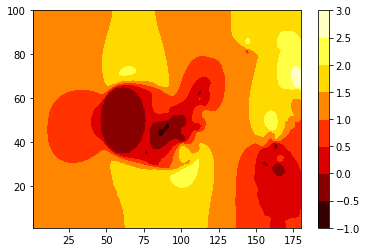

In [16]:
# print cfd.t.unique()

t0 = 1000

x = cfd.i.unique()
y = cfd.k.unique()

X, Y = np.meshgrid(x,y)
nx,ny = X.shape

Z = cfd[cfd.t == t0].U.values.reshape(nx,ny)
plt.contourf(X,Y,Z, cmap='hot')
plt.colorbar()

plt.show()

In [8]:

imax  = cfd.i.max()
imin  = cfd.i.min()
kmax  = cfd.k.max()
kmin  = cfd.k.min()
tmin  = cfd.t.min()
tmax  = cfd.t.max()
tsteps = cfd.t.unique()
print imin, imax, kmin,kmax, tmin, tmax#,tsteps


1 180 1 100 1 5


In [128]:
def writehead():
    varstring = '"i","k","U","W","spd","vort","F"'
    f = open("annoutfield.dat", "w")
    f.write('Title = "ANN Movie"\n')
    f.write('Variables='+varstring+'\n')
    print("writing head of moviefile...")

    
def writezone(df,n):
    print 'writing zone n = ',n
    f = open("annoutfield.dat", "a")
    annout = df[df.t==n]

    f.write('Zone T=\"n='+str(n)+'\",I= '+str(imax)+', K='+str(kmax)+',F = POINT \n')

    for kk in range(1,kmax+1):
        for ii in range(1,imax+1):

            ikann = annout[(annout.i == ii) & (annout.k == kk)]
            iii = str(ikann.i.values[0])+' '
            kkk = str(ikann.k.values[0])+' '
            UUU = str(ikann.U.values[0])+' '
            WWW = str(ikann.W.values[0])+' '
            spd = str(ikann.spd.values[0])+' '
            vor = str(ikann.vort.values[0])+' '
            F   = str(ikann.F.values[0])+'\n'

            line = iii+kkk+UUU+WWW+spd+vor+F

            f.write(line)
    

In [ ]:
trainfile = open("traindataVCtest.dat", "w")
trainfile.write("U W U0 W0 U1 W1 U2 W2 U3 W3 U4 W4 U5 W5 U6 W6 U7 W7 isfluid Up Wp \n")
trainfile.close()

iimin = 25
iimax = 150
kkmin = 10
kkmax = 90
ttmin = tmin
ttmax = tmax


trainfile = open("traindataVCtest.dat", "a")




for t in range(ttmin,ttmax,50):
    print 't = ',t
    print(datetime.now().time())
    
    cfdt  = cfd[(cfd.t == t) & 
           (cfd.i>iimin-2) & 
           (cfd.i<iimax+2) & 
           (cfd.k>kkmin-2) &
           (cfd.k<kkmax+2)]
    print 't   ',cfdt.t.unique()
        
    cfdtp1 = cfd[(cfd.t == t+1) & 
               (cfd.i>iimin-2) & 
               (cfd.i<iimax+2) & 
               (cfd.k>kkmin-2) &
               (cfd.k<kkmax+2)]
    
    print 't+1 ',cfdtp1.t.unique()
    
    for i in range(iimin,iimax):
        for k in range(kkmin,kkmax):
            
            
            stencil =  cfdt[(cfdt.t == t) & 
                            (cfdt.i>i-2) & 
                            (cfdt.i<i+2) & 
                            (cfdt.k>k-2) &
                            (cfdt.k<k+2)]
            
            U  = stencil[(stencil.i == i)   & (stencil.k == k)].U.values[0]
            W  = stencil[(stencil.i == i)   & (stencil.k == k)].W.values[0]
            U0 = stencil[(stencil.i == i+1) & (stencil.k == k)].U.values[0]
            W0 = stencil[(stencil.i == i+1) & (stencil.k == k)].W.values[0]
            U1 = stencil[(stencil.i == i+1) & (stencil.k == k+1)].U.values[0]
            W1 = stencil[(stencil.i == i+1) & (stencil.k == k+1)].W.values[0]
            U2 = stencil[(stencil.i == i)   & (stencil.k == k+1)].U.values[0]
            W2 = stencil[(stencil.i == i)   & (stencil.k == k+1)].W.values[0]
            U3 = stencil[(stencil.i == i-1) & (stencil.k == k+1)].U.values[0]
            W3 = stencil[(stencil.i == i-1) & (stencil.k == k+1)].W.values[0]
            U4 = stencil[(stencil.i == i-1) & (stencil.k == k)].U.values[0]
            W4 = stencil[(stencil.i == i-1) & (stencil.k == k)].W.values[0]
            U5 = stencil[(stencil.i == i-1) & (stencil.k == k-1)].U.values[0]
            W5 = stencil[(stencil.i == i-1) & (stencil.k == k-1)].W.values[0]
            U6 = stencil[(stencil.i == i)   & (stencil.k == k-1)].U.values[0]
            W6 = stencil[(stencil.i == i)   & (stencil.k == k-1)].W.values[0]
            U7 = stencil[(stencil.i == i+1) & (stencil.k == k-1)].U.values[0]
            W7 = stencil[(stencil.i == i+1) & (stencil.k == k-1)].W.values[0]
            F  = stencil[(stencil.i == i)   & (stencil.k == k)].F.values[0]
            
            
#             U  = cfdt[(cfdt.i == i) & (cfdt.k == k)].U.values[0]
#             W  = cfdt[(cfdt.i == i) & (cfdt.k == k)].W.values[0]
#             U0 = cfdt[(cfdt.i == i+1) & (cfdt.k == k)].U.values[0]
#             W0 = cfdt[(cfdt.i == i+1) & (cfdt.k == k)].W.values[0]
#             U1 = cfdt[(cfdt.i == i+1) & (cfdt.k == k+1)].U.values[0]
#             W1 = cfdt[(cfdt.i == i+1) & (cfdt.k == k+1)].W.values[0]
#             U2 = cfdt[(cfdt.i == i) & (cfdt.k == k+1)].U.values[0]
#             W2 = cfdt[(cfdt.i == i) & (cfdt.k == k+1)].W.values[0]
#             U3 = cfdt[(cfdt.i == i-1) & (cfdt.k == k+1)].U.values[0]
#             W3 = cfdt[(cfdt.i == i-1) & (cfdt.k == k+1)].W.values[0]
#             U4 = cfdt[(cfdt.i == i-1) & (cfdt.k == k)].U.values[0]
#             W4 = cfdt[(cfdt.i == i-1) & (cfdt.k == k)].W.values[0]
#             U5 = cfdt[(cfdt.i == i-1) & (cfdt.k == k-1)].U.values[0]
#             W5 = cfdt[(cfdt.i == i-1) & (cfdt.k == k-1)].W.values[0]
#             U6 = cfdt[(cfdt.i == i) & (cfdt.k == k-1)].U.values[0]
#             W6 = cfdt[(cfdt.i == i) & (cfdt.k == k-1)].W.values[0]
#             U7 = cfdt[(cfdt.i == i+1) & (cfdt.k == k-1)].U.values[0]
#             W7 = cfdt[(cfdt.i == i+1) & (cfdt.k == k-1)].W.values[0]
#             F = cfdt[(cfdt.i == i) & (cfdt.k == k)].F.values[0]

            #from future stencil, no prefiltering
            Up = cfdtp1[(cfdtp1.i == i) & (cfdtp1.k == k)].U.values[0]
            Wp = cfdtp1[(cfdtp1.i == i) & (cfdtp1.k == k)].W.values[0]
            


            if (F>0):
                isfluid = 1
            else:
                isfluid = 0
            line = ''
            for dd in [U,W,U0,W0,U1,W1,U2,W2,U3,W3,U4,W4,U5,W5,U6,W6,U7,W7,isfluid,Up,Wp]:
                line += str(dd)+' '
            line+='\n'

            trainfile.write(line)

            

trainfile.close()
# print U,W
# print Up,Wp
#         for 

In [254]:
trainfile = open("refdata.dat", "w")
trainfile.write("U W U0 W0 U1 W1 U2 W2 U3 W3 U4 W4 U5 W5 U6 W6 U7 W7 isfluid Up Wp \n")
trainfile.close()

iimin = 30
iimax = 130
kkmin = 40
kkmax = 60


trainfile = open("refdata.dat", "a")
for t in range(1750,1999,60):
    print 't = ',t
    
    cfdt  = cfd[(cfd.t == t) & 
           (cfd.i>iimin-2) & 
           (cfd.i<iimax+2) & 
           (cfd.k>kkmin-2) &
           (cfd.k<kkmax+2)]
    print 't   ',cfdt.t.unique()
        
    cfdtp1 = cfd[(cfd.t == t+1) & 
               (cfd.i>iimin-2) & 
               (cfd.i<iimax+2) & 
               (cfd.k>kkmin-2) &
               (cfd.k<kkmax+2)]
    
    print 't+1 ',cfdtp1.t.unique()
    
    for i in range(iimin,iimax):
        for k in range(kkmin,kkmax):
            U  = cfdt[(cfdt.i == i) & (cfdt.k == k)].U.values[0]
            W  = cfdt[(cfdt.i == i) & (cfdt.k == k)].W.values[0]
            U0 = cfdt[(cfdt.i == i+1) & (cfdt.k == k)].U.values[0]
            W0 = cfdt[(cfdt.i == i+1) & (cfdt.k == k)].W.values[0]
            U1 = cfdt[(cfdt.i == i+1) & (cfdt.k == k+1)].U.values[0]
            W1 = cfdt[(cfdt.i == i+1) & (cfdt.k == k+1)].W.values[0]
            U2 = cfdt[(cfdt.i == i) & (cfdt.k == k+1)].U.values[0]
            W2 = cfdt[(cfdt.i == i) & (cfdt.k == k+1)].W.values[0]
            U3 = cfdt[(cfdt.i == i-1) & (cfdt.k == k+1)].U.values[0]
            W3 = cfdt[(cfdt.i == i-1) & (cfdt.k == k+1)].W.values[0]
            U4 = cfdt[(cfdt.i == i-1) & (cfdt.k == k)].U.values[0]
            W4 = cfdt[(cfdt.i == i-1) & (cfdt.k == k)].W.values[0]
            U5 = cfdt[(cfdt.i == i-1) & (cfdt.k == k-1)].U.values[0]
            W5 = cfdt[(cfdt.i == i-1) & (cfdt.k == k-1)].W.values[0]
            U6 = cfdt[(cfdt.i == i) & (cfdt.k == k-1)].U.values[0]
            W6 = cfdt[(cfdt.i == i) & (cfdt.k == k-1)].W.values[0]
            U7 = cfdt[(cfdt.i == i+1) & (cfdt.k == k-1)].U.values[0]
            W7 = cfdt[(cfdt.i == i+1) & (cfdt.k == k-1)].W.values[0]
            Up = cfdtp1[(cfdtp1.i == i) & (cfdtp1.k == k)].U.values[0]
            Wp = cfdtp1[(cfdtp1.i == i) & (cfdtp1.k == k)].W.values[0]
            F = cfdt[(cfdt.i == i) & (cfdt.k == k)].F.values[0]
            if (F>0):
                isfluid = 1
            else:
                isfluid = 0
            line = ''
            for dd in [U,W,U0,W0,U1,W1,U2,W2,U3,W3,U4,W4,U5,W5,U6,W6,U7,W7,isfluid,Up,Wp]:
                line += str(dd)+' '
            line+='\n'

            trainfile.write(line)

            
print 'Done'
trainfile.close()
# print U,W
# print Up,Wp
#         for 

t =  1750
t    [1750]
t+1  [1751]
t =  1810
t    [1810]
t+1  [1811]
t =  1870
t    [1870]
t+1  [1871]
t =  1930
t    [1930]
t+1  [1931]
t =  1990
t    [1990]
t+1  [1991]
